-334 480 181 288


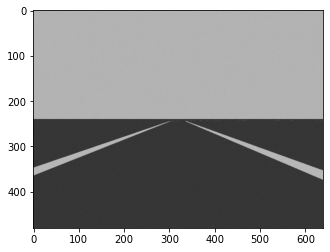

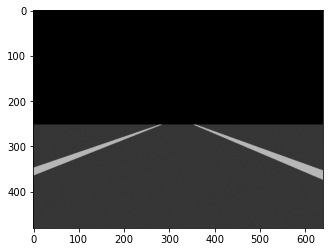

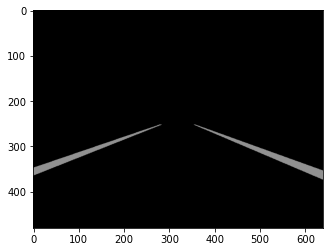

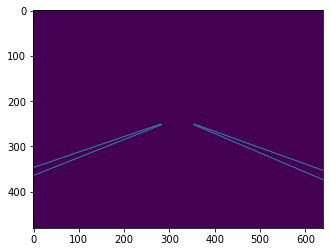

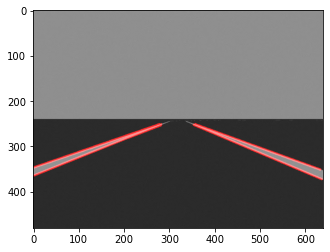

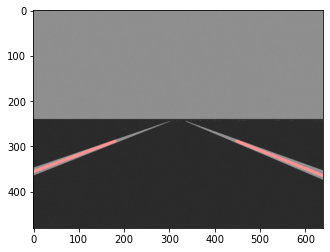

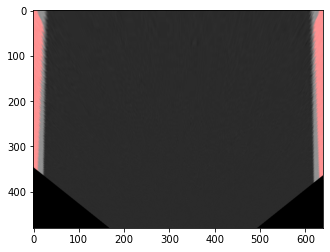

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = [255, 255, 255]  # <-- This line altered for grayscale.
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

image = mpimg.imread('solidWhiteCurve.jpg')
height = image.shape[0]
width = image.shape[1]
region_of_interest_vertices = [
    (0, height),
    (0, height / 1.9),
    (width, height / 1.9),
    (width, height),
]

mask = np.zeros_like(image)
match_mask_color = [255, 255, 255]  # <-- This line altered for grayscale.
cv2.fillPoly(mask, np.int32([region_of_interest_vertices]), match_mask_color)
cropped_image = cv2.bitwise_and(image, mask)

ret, thresh_image = cv2.threshold(cropped_image, 130, 145, cv2.THRESH_BINARY)

cannyed_image = cv2.Canny(thresh_image, 50, 150)




lines = cv2.HoughLinesP(cannyed_image, 1, np.pi/180, 30, maxLineGap=100)

left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []

for line in lines:
    for x1, y1, x2, y2 in line:
        slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        if math.fabs(slope) < 0.3: # <-- Only consider extreme slope
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])

line_image = draw_lines(image, lines) # <---- Add this call.

min_y = int(image.shape[0] * (3/5)) # <-- Just below the horizon
max_y = int(image.shape[0]) # <-- The bottom of the image
poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))
left_x_start = int(poly_left(max_y))
left_x_end = int(poly_left(min_y))
poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))
right_x_start = int(poly_right(max_y))
right_x_end = int(poly_right(min_y))

print(left_x_start, max_y, left_x_end, min_y)

extrapolated_line_image = draw_lines(
    image,
    [[
        [left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
    ]],
    thickness=5,
)

imgTl = [0,0]
imgTr = [width,0]
imgBr = [width,height]
imgBl = [0,height]
img_params = np.float32([imgTl,imgTr,imgBr,imgBl])

    
tl = [left_x_end, min_y]
tr = [right_x_end, min_y]
br = [right_x_start, max_y]
bl = [left_x_start, max_y]
corner_points_array = np.float32([tl,tr,br,bl])

matrix = cv2.getPerspectiveTransform(corner_points_array,img_params)
transformed_image = cv2.warpPerspective(extrapolated_line_image,matrix,(width,height))

plt.figure()
plt.imshow(image)

plt.figure()
plt.imshow(cropped_image)

plt.figure()
plt.imshow(thresh_image)

plt.figure()
plt.imshow(cannyed_image)

plt.figure()
plt.imshow(line_image)

plt.figure()
plt.imshow(extrapolated_line_image)

plt.figure()
plt.imshow(transformed_image)


In [11]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    # Return the modified image.
    return img

In [ ]:
#!/usr/bin/env python3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import cv_bridge
import rclpy 
from rclpy.node import Node
from sensor_msgs.msg import Image


class getCameraDataNode(Node):
    def __init__(self):
        super().__init__("getCamDataNode")
        self.bridge = cv_bridge.CvBridge()
        self.image_sub = self.create_subscription(Image, "/camera/image_raw", self.handle_camera_data, 10)

    def handle_camera_data(self,msg):
        global perr, ptime, serr, dt
        image = self.bridge.imgmsg_to_cv2(msg,desired_encoding='bgr8')
        #transformation
        height = image.shape[0]
        width = image.shape[1]
        region_of_interest_vertices = [
            (0, height),
            (0, height / 1.9),
            (width, height / 1.9),
            (width, height),
        ]

        mask = np.zeros_like(image)
        match_mask_color = [255, 255, 255]  # <-- This line altered for grayscale.
        cv2.fillPoly(mask, np.int32([region_of_interest_vertices]), match_mask_color)
        cropped_image = cv2.bitwise_and(image, mask)

        ret, thresh_image = cv2.threshold(cropped_image, 130, 145, cv2.THRESH_BINARY)

        cannyed_image = cv2.Canny(thresh_image, 50, 150)

        lines = cv2.HoughLinesP(cannyed_image, 1, np.pi/180, 30, maxLineGap=100)

        left_line_x = []
        left_line_y = []
        right_line_x = []
        right_line_y = []

        for line in lines:
            for x1, y1, x2, y2 in line:
                slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
                if math.fabs(slope) < 0.3: # <-- Only consider extreme slope
                    continue
                if slope <= 0: # <-- If the slope is negative, left group.
                    left_line_x.extend([x1, x2])
                    left_line_y.extend([y1, y2])
                else: # <-- Otherwise, right group.
                    right_line_x.extend([x1, x2])
                    right_line_y.extend([y1, y2])

        line_image = self.draw_lines(image, lines) # <---- Add this call.

        min_y = int(image.shape[0] * (3/5)) # <-- Just below the horizon
        max_y = int(image.shape[0]) # <-- The bottom of the image
        poly_left = np.poly1d(np.polyfit(
            left_line_y,
            left_line_x,
            deg=1
        ))
        left_x_start = int(poly_left(max_y))
        left_x_end = int(poly_left(min_y))
        poly_right = np.poly1d(np.polyfit(
            right_line_y,
            right_line_x,
            deg=1
        ))
        right_x_start = int(poly_right(max_y))
        right_x_end = int(poly_right(min_y))

        print(left_x_start, max_y, left_x_end, min_y)

        extrapolated_line_image = self.draw_lines(
            image,
            [[
                [left_x_start, max_y, left_x_end, min_y],
                [right_x_start, max_y, right_x_end, min_y],
            ]],
            thickness=5,
        )

        imgTl = [0,0]
        imgTr = [width,0]
        imgBr = [width,height]
        imgBl = [0,height]
        img_params = np.float32([imgTl,imgTr,imgBr,imgBl])

            
        tl = [left_x_end, min_y]
        tr = [right_x_end, min_y]
        br = [right_x_start, max_y]
        bl = [left_x_start, max_y]
        corner_points_array = np.float32([tl,tr,br,bl])

        matrix = cv2.getPerspectiveTransform(corner_points_array,img_params)
        transformed_image = cv2.warpPerspective(extrapolated_line_image,matrix,(width,height))

        cv2.imshow("original_image", image) 
        cv2.imshow("transformed_image", extrapolated_line_image)
        cv2.imshow("transformed_image", transformed_image) 
        cv2.waitKey(2)

    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=3):
        # If there are no lines to draw, exit.
        if lines is None:
            return
        # Make a copy of the original image.
        img = np.copy(img)
        # Create a blank image that matches the original in size.
        line_img = np.zeros(
            (
                img.shape[0],
                img.shape[1],
                3
            ),
            dtype=np.uint8,
        )
        # Loop over all lines and draw them on the blank image.
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
        # Merge the image with the lines onto the original.
        img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
        # Return the modified image.
        return img


    